# Recommendation System Analysis with t-SNE and Tensorflow 

Fixed from origin source: [https://github.com/google/eng-edu/blob/main/ml/recommendation-systems/recommendation-systems.ipynb](https://github.com/google/eng-edu/blob/main/ml/recommendation-systems/recommendation-systems.ipynb)

In [1]:
from __future__ import print_function

import numpy as np 
import pandas as pd 
import collections 
from mpl_toolkits.mplot3d import Axes3D
from IPython import display 
from matplotlib import pyplot as plt
import sklearn 
import sklearn.manifold 
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

pd.options.display.max_rows = 10   
pd.options.display.float_format = '{:.3f}'.format

def mask(df, key, function):
    """Return a filtered dataframe."""
    return df[function(df[key])]

def flatten_cols(df):
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    return df 

pd.DataFrame.mask = mask 
pd.DataFrame.flatten_cols = flatten_cols

import altair as alt 
alt.data_transformers.enable('default', max_rows=None) 
alt.renderers.enable('colab')

USER_RATINGS = True 


2024-02-15 07:06:31.686148: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-15 07:06:31.710875: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 07:06:31.710901: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 07:06:31.711510: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 07:06:31.715646: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import os
import zipfile
from urllib.request import urlretrieve

zip_file_path = 'movielens.zip'

if not os.path.exists(zip_file_path):
    urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", zip_file_path)
    zip_ref = zipfile.ZipFile(zip_file_path, 'r')
    zip_ref.extractall()
    zip_ref.close()
    print("Complete extract")


In [3]:
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

rating_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=rating_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = ['movie_id', 'title', 'release_date', "video_release_date", "imdb_url"] + genre_cols
movies = pd.read_csv('ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

In [4]:
users['user_id'] = users['user_id'].apply(lambda x: str(x-1))
movies['movie_id'] = movies['movie_id'].apply(lambda x: str(x-1))
movies['year'] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings['movie_id'] = ratings['movie_id'].apply(lambda x: str(x-1))
ratings['user_id'] = ratings['user_id'].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

In [5]:
genre_occurences = movies[genre_cols].sum().to_dict()
genre_occurences

{'genre_unknown': 2,
 'Action': 251,
 'Adventure': 135,
 'Animation': 42,
 'Children': 122,
 'Comedy': 505,
 'Crime': 109,
 'Documentary': 50,
 'Drama': 725,
 'Fantasy': 22,
 'Film-Noir': 24,
 'Horror': 92,
 'Musical': 56,
 'Mystery': 61,
 'Romance': 247,
 'Sci-Fi': 101,
 'Thriller': 251,
 'War': 71,
 'Western': 27}

In [6]:
# since one movie can have many genres
def mark_genres(movies, genres):
    def get_random_genre(gs):
        active = [genre for genre, g in zip(genres, gs) if g==1]
        if len(active) == 0:
            return 'Other'
        return np.random.choice(active)
    
    def get_all_genres(gs):
        active = [genre for genre, g in zip(genres, gs) if g==1]
        if len(active) == 0:
            return 'Other'
        return '-'.join(active)

    # convert list into tuples
    movies['genre'] = [get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
    movies['all_genres'] = [get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

In [7]:
movies

movie_id                                      title release_date  \
0           0                           Toy Story (1995)  01-Jan-1995   
1           1                           GoldenEye (1995)  01-Jan-1995   
2           2                          Four Rooms (1995)  01-Jan-1995   
3           3                          Get Shorty (1995)  01-Jan-1995   
4           4                             Copycat (1995)  01-Jan-1995   
...       ...                                        ...          ...   
1677     1677                          Mat' i syn (1997)  06-Feb-1998   
1678     1678                           B. Monkey (1998)  06-Feb-1998   
1679     1679                       Sliding Doors (1998)  01-Jan-1998   
1680     1680                        You So Crazy (1994)  01-Jan-1994   
1681     1681  Scream of Stone (Schrei aus Stein) (1991)  08-Mar-1996   

      video_release_date                                           imdb_url  \
0                    NaN  http://us.imdb.com/M/title-exact?Toy%20Story%2...   
1                    NaN  http://us.imdb.com/M/title-exact?GoldenEye%20(...   
2                    NaN  http://us.imdb.com/M/title-exact?Four%20Rooms%...   
3                    NaN  http://us.imdb.com/M/title-exact?Get%20Shorty%...   
4                    NaN  http://us.imdb.com/M/title-exact?Copycat%20(1995)   
...                  ...                                                ...   
1677                 NaN  http://us.imdb.com/M/title-exact?Mat%27+i+syn+...   
1678                 NaN  http://us.imdb.com/M/title-exact?B%2E+Monkey+(...   
1679                 NaN      http://us.imdb.com/Title?Sliding+Doors+(1998)   
1680                 NaN  http://us.imdb.com/M/title-exact?You%20So%20Cr...   
1681                 NaN  http://us.imdb.com/M/title-exact?Schrei%20aus%...   

      genre_unknown  Action  Adventure  Animation  Children  ...  Musical  \
0                 0       0          0          1         1  ...        0   
1                 0       1          1          0         0  ...        0   
2                 0       0          0          0         0  ...        0   
3                 0       1          0          0         0  ...        0   
4                 0       0          0          0         0  ...        0   
...             ...     ...        ...        ...       ...  ...      ...   
1677              0       0          0          0         0  ...        0   
1678              0       0          0          0         0  ...        0   
1679              0       0          0          0         0  ...        0   
1680              0       0          0          0         0  ...        0   
1681              0       0          0          0         0  ...        0   

      Mystery  Romance  Sci-Fi  Thriller  War  Western  year      genre  \
0           0        0       0         0    0        0  1995  Animation   
1           0        0       0         1    0        0  1995   Thriller   
2           0        0       0         1    0        0  1995   Thriller   
3           0        0       0         0    0        0  1995     Action   
4           0        0       0         1    0        0  1995      Crime   
...       ...      ...     ...       ...  ...      ...   ...        ...   
1677        0        0       0         0    0        0  1998      Drama   
1678        0        1       0         1    0        0  1998   Thriller   
1679        0        1       0         0    0        0  1998    Romance   
1680        0        0       0         0    0        0  1994     Comedy   
1681        0        0       0         0    0        0  1996      Drama   

                     all_genres  
0     Animation-Children-Comedy  
1     Action-Adventure-Thriller  
2                      Thriller  
3           Action-Comedy-Drama  
4          Crime-Drama-Thriller  
...                         ...  
1677                      Drama  
1678           Romance-Thriller  
1679              Drama-Romance  
1680         

In [8]:
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

def split_dataframe(df, holdout_fraction=0.1):
    """
    Split dataframe into training and test set
    """
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]

    return train, test

In [9]:
users.describe()

age
count 943.000
mean   34.052
std    12.193
min     7.000
25%    25.000
50%    31.000
75%    43.000
max    73.000

In [10]:
users.describe(include=[object])

user_id  sex occupation zip_code
count      943  943        943      943
unique     943    2         21      795
top        942    M    student    55414
freq         1  670        196        9

In [11]:
# Create filters to be used to slice the data.
occupation_filter = alt.selection_point(fields=["occupation"])
occupation_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y("occupation:N"),
    color=alt.condition(
        occupation_filter,
        alt.Color("occupation:N", scale=alt.Scale(scheme='category20')),
        alt.value("lightgray")),
).properties(width=300, height=300).add_params(occupation_filter)

# A function that generates a histogram of filtered data.
def filtered_hist(field, label, filter):
  """Creates a layered chart of histograms.
  The first layer (light gray) contains the histogram of the full data, and the
  second contains the histogram of the filtered data.
  Args:
    field: the field for which to generate the histogram.
    label: String label of the histogram.
    filter: an alt.Selection object to be used to filter the data.
  """
  base = alt.Chart().mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
      y="count()",
  ).properties(
      width=300,
  )
  
  return alt.layer(
      base.transform_filter(filter),
      base.encode(color=alt.value('lightgray'), opacity=alt.value(.7)),
  ).resolve_scale(y='independent')

users_ratings = (
    ratings
    .groupby('user_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols()
    .merge(users, on='user_id')
)

users_ratings


user_id  rating count  rating mean  age sex  occupation zip_code
0         0           272        3.610   24   M  technician    85711
1         1            62        3.710   53   F       other    94043
2        10           181        3.464   39   F       other    30329
3       100            67        2.896   15   M     student    05146
4       101           216        2.616   38   M  programmer    30220
..      ...           ...          ...  ...  ..         ...      ...
938      95            56        4.268   25   F      artist    75206
939      96            63        4.159   43   M      artist    98006
940      97            27        3.593   49   F   executive    90291
941      98           136        3.551   20   M     student    63129
942      99            59        3.068   36   M   executive    90254

[943 rows x 7 columns]

In [12]:
# Create a chart for the count, and one for the mean.
alt.hconcat(
    filtered_hist('rating count', '# ratings / user', occupation_filter),
    filtered_hist('rating mean', 'mean user rating', occupation_filter),
    occupation_chart,
    data=users_ratings)

alt.HConcatChart(...)

In [13]:
movies_ratings = movies.merge(
    ratings
    .groupby('movie_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='movie_id')

genre_filter = alt.selection_point(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300,).add_params(genre_filter)

In [14]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .sort_values('rating count', ascending=False)
 .head(10))

title  rating count  rating mean
49                Star Wars (1977)           583        4.358
257                 Contact (1997)           509        3.804
99                    Fargo (1996)           508        4.156
180      Return of the Jedi (1983)           507        4.008
293               Liar Liar (1997)           485        3.157
285    English Patient, The (1996)           481        3.657
287                  Scream (1996)           478        3.441
0                 Toy Story (1995)           452        3.878
299           Air Force One (1997)           431        3.631
120  Independence Day (ID4) (1996)           429        3.438

In [15]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .mask('rating count', lambda x: x > 20)
 .sort_values('rating mean', ascending=False)
 .head(10))

title  rating count  \
407                              Close Shave, A (1995)           112   
317                            Schindler's List (1993)           298   
168                         Wrong Trousers, The (1993)           118   
482                                  Casablanca (1942)           243   
113  Wallace & Gromit: The Best of Aardman Animatio...            67   
63                    Shawshank Redemption, The (1994)           283   
602                                 Rear Window (1954)           209   
11                          Usual Suspects, The (1995)           267   
49                                    Star Wars (1977)           583   
177                                12 Angry Men (1957)           125   

     rating mean  
407        4.491  
317        4.466  
168        4.466  
482        4.457  
113        4.448  
63         4.445  
602        4.388  
11         4.386  
49         4.358  
177        4.344

In [16]:
alt.hconcat(
    filtered_hist('rating count', '# ratings / movie', genre_filter),
    filtered_hist('rating mean', 'mean movie rating', genre_filter),
    genre_chart,
    data=movies_ratings)

alt.HConcatChart(...)

# II. Preliminaries

Our goal is to factorize the ratings matrix $A$ into the product of a user embedding matrix $U$ and movie embedding matrix $V$, such that $A \approx UV^\top$ with
$U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ and
$V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$.

Here
- $N$ is the number of users,
- $M$ is the number of movies,
- $A_{ij}$ is the rating of the $j$th movies by the $i$th user,
- each row $U_i$ is a $d$-dimensional vector (embedding) representing user $i$,
- each row $V_j$ is a $d$-dimensional vector (embedding) representing movie $j$,
- the prediction of the model for the $(i, j)$ pair is the dot product $\langle U_i, V_j \rangle$.

We can use `tf.SparseTensor` to handle the sparse data. `tf.SparseTensor(indices, values, dense_shape)` with explanation:
`indices` contain location of non-zero rating value 
`values` the values 
`dense_shape` the size of matrix



In [17]:
def build_rating_sparse_tensor(ratings_df):
    indices = ratings_df[['user_id', 'movie_id']].values
    values = ratings_df['rating'].values

    return tf.SparseTensor(indices=indices, values=values, dense_shape=[users.shape[0], movies.shape[0]])


The function build_rating_sparse_tensor is used to convert a DataFrame of movie ratings into a sparse tensor. This is useful in situations where the data is sparse, such as a movie recommendation system where each user has only rated a small subset of all available movies.

Here's a breakdown of what each part of the function does:

indices = ratings_df[['user_id', 'movie_id']].values: This line extracts the user IDs and movie IDs from the DataFrame and stores them as a 2D array. These IDs will be used as the indices of the non-zero values in the sparse tensor.

values = ratings_df['rating'].values: This line extracts the ratings from the DataFrame and stores them as a 1D array. These ratings will be the non-zero values in the sparse tensor.

return tf.SparseTensor(indices=indices, values=values, dense_shape=[users.shape[0], movies.shape[0]]): This line creates a sparse tensor using the indices and values. The shape of the tensor is determined by the number of users and movies, which are assumed to be defined elsewhere in the code.

## Calculating the error

The model approximates the ratings matrix $A$ by a low-rank product $UV^\top$. We need a way to measure the approximation error. We'll start by using the Mean Squared Error of observed entries only (we will revisit this later). It is defined as

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$
where $\Omega$ is the set of observed ratings, and $|\Omega|$ is the cardinality of $\Omega$.



In [18]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
    predictions = tf.gather_nd(
        tf.matmul(user_embeddings, movie_embeddings, transpose_b=True),
        sparse_ratings.indices
    )
    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)

    return loss

The function `sparse_mean_square_error` calculates the mean squared error (MSE) between the actual ratings and the predicted ratings for a recommendation system. This function is designed to work with sparse data, which is common in recommendation systems because users typically only rate a small subset of all possible items.

Here's a breakdown of what each part of the function does:

- `tf.matmul(user_embeddings, movie_embeddings, transpose_b=True)`: This line calculates the dot product between the user embeddings and the movie embeddings. The `transpose_b=True` argument means that the movie embeddings are transposed before the multiplication. The result of this operation is a matrix where each element is the dot product of a user embedding and a movie embedding, which represents the predicted rating that the user would give to the movie.

- `tf.gather_nd(..., sparse_ratings.indices)`: This line uses the `tf.gather_nd` function to select the predicted ratings that correspond to the actual ratings in the sparse ratings tensor. The `sparse_ratings.indices` tensor contains the indices of the actual ratings, so this line effectively filters out the predicted ratings that we're interested in.

- `tf.losses.mean_squared_error(sparse_ratings.values, predictions)`: This line calculates the mean squared error between the actual ratings and the predicted ratings. The MSE is a common loss function for regression problems, and it's used here to quantify the difference between the actual ratings and the predicted ratings.

- `return loss`: This line returns the calculated MSE.

So, in summary, this function takes in the actual ratings and the user and movie embeddings, predicts the ratings based on the embeddings, and then calculates and returns the mean squared error between the actual ratings and the predicted ratings.

In [19]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
    predictions = tf.reduce_sum(
        tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
        tf.gather(movie_embeddings, sparse_ratings.indices[:, 1]),
        axis=1
    )

    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)

    return loss

The two functions sparse_mean_square_error are similar in that they both calculate the mean squared error between actual and predicted ratings for a recommendation system. However, they differ in how they compute the predictions.

In the first function, the predictions are computed using matrix multiplication (tf.matmul) between the user embeddings and the movie embeddings (with the movie embeddings being transposed). This results in a matrix where each element is the dot product of a user embedding and a movie embedding, representing the predicted rating that the user would give to the movie. Then, tf.gather_nd is used to select the predicted ratings that correspond to the actual ratings in the sparse ratings tensor.

In the second function, the predictions are computed differently. First, tf.gather is used to select the user embeddings and movie embeddings that correspond to the actual ratings in the sparse ratings tensor. Then, these selected embeddings are multiplied element-wise, and tf.reduce_sum is used to sum the results along axis 1, resulting in a 1D tensor of predicted ratings.

In summary, both functions aim to predict ratings based on user and movie embeddings and then compute the mean squared error between these predictions and the actual ratings. However, they use different methods to compute the predictions. The first function uses matrix multiplication and works with the entire embeddings matrices at once, while the second function selects relevant embeddings first and then performs element-wise multiplication and summation.

In [20]:
# adding my own ratings 
if USER_RATINGS:
    filtered_movies_ratings = movies_ratings[(movies_ratings['rating count'] > 50) & (movies_ratings['rating mean'] > 4)]
    filtered_movies_ratings = filtered_movies_ratings.sample(n=100, replace=True)
    
    my_ratings = pd.DataFrame({
        'user_id': '943',
        'movie_id': filtered_movies_ratings['movie_id'],
        'rating': np.random.choice([3, 4, 5], size=100, replace=True)
    })

    ratings = ratings[ratings['user_id'] != '943']
    ratings = pd.concat([ratings, my_ratings], ignore_index=True)

    if users.shape[0] == 943:
        users = pd.concat([users, users.iloc[942]], ignore_index=True)
        users['user_id'][943] = "943"
    
    ratings[ratings.user_id == '943'].merge(movies[['movie_id', 'title']])

/tmp/ipykernel_37837/3427672340.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users['user_id'][943] = "943"


In [21]:
class CFModel(object):
    def __init__(self, embedding_vars, loss, metrics=None):
        self._embedding_vars = embedding_vars 
        self._loss = loss 
        self._metrics = metrics
        self._embeddings = {k: None for k in embedding_vars}
        self._session = None 
    
    @property 
    def embeddings(self):
        return self._embeddings

    def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
        optimizer=tf.train.GradientDescentOptimizer):

        with self._loss.graph.as_default():
            opt = optimizer(learning_rate)
            train_op = opt.minimize(self._loss)
            local_init_op = tf.group(
                tf.variables_initializer(opt.variables()),
                tf.local_variables_initializer())

            if self._session is None:
                self._session = tf.Session()
                with self._session.as_default():
                    self._session.run(tf.global_variables_initializer())
                    self._session.run(tf.tables_initializer())
                    tf.train.start_queue_runners()

        with self._session.as_default():
            local_init_op.run()
            iterations = []
            metrics = self._metrics or ({},)
            metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

            # Train and append results.
            for i in range(num_iterations + 1):
                _, results = self._session.run((train_op, metrics))
                if (i % 10 == 0) or i == num_iterations:
                    print("\r iteration %d: " % i + ", ".join(
                        ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                        end='')
                    
                iterations.append(i)
                for metric_val, result in zip(metrics_vals, results):
                    for k, v in result.items():
                        metric_val[k].append(v)

            for k, v in self._embedding_vars.items():
                self._embeddings[k] = v.eval()

            if plot_results:
                # Plot the metrics.
                num_subplots = len(metrics)+1
                fig = plt.figure()
                fig.set_size_inches(num_subplots*10, 8)
                for i, metric_vals in enumerate(metrics_vals):
                    ax = fig.add_subplot(1, num_subplots, i+1)
                for k, v in metric_vals.items():
                    ax.plot(iterations, v, label=k)
                ax.set_xlim([1, num_iterations])
                ax.legend()
                
            return results

In [22]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
    """
    Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
    Returns:
    model: a CFModel.
    """
    # Split the ratings DataFrame into train and test.
    train_ratings, test_ratings = split_dataframe(ratings)
    # SparseTensor representation of the train and test datasets.
    A_train = build_rating_sparse_tensor(train_ratings)
    A_test = build_rating_sparse_tensor(test_ratings)
    # Initialize the embeddings using a normal distribution.
    U = tf.Variable(tf.random_normal(
        [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random_normal(
        [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
    train_loss = sparse_mean_square_error(A_train, U, V)
    test_loss = sparse_mean_square_error(A_test, U, V)
    metrics = {
        'train_error': train_loss,
        'test_error': test_loss
    }
    embeddings = {
        "user_id": U,
        "movie_id": V
    }
    return CFModel(embeddings, train_loss, [metrics])

2024-02-15 07:06:33.817103: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-02-15 07:06:33.817123: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: pc
2024-02-15 07:06:33.817127: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: pc
2024-02-15 07:06:33.817196: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.154.5
2024-02-15 07:06:33.817208: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.154.5
2024-02-15 07:06:33.817212: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.154.5
2024-02-15 07:06:33.819841: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


 iteration 1000: train_error=0.341627, test_error=1.534450

[{'train_error': 0.34162652, 'test_error': 1.5344502}]

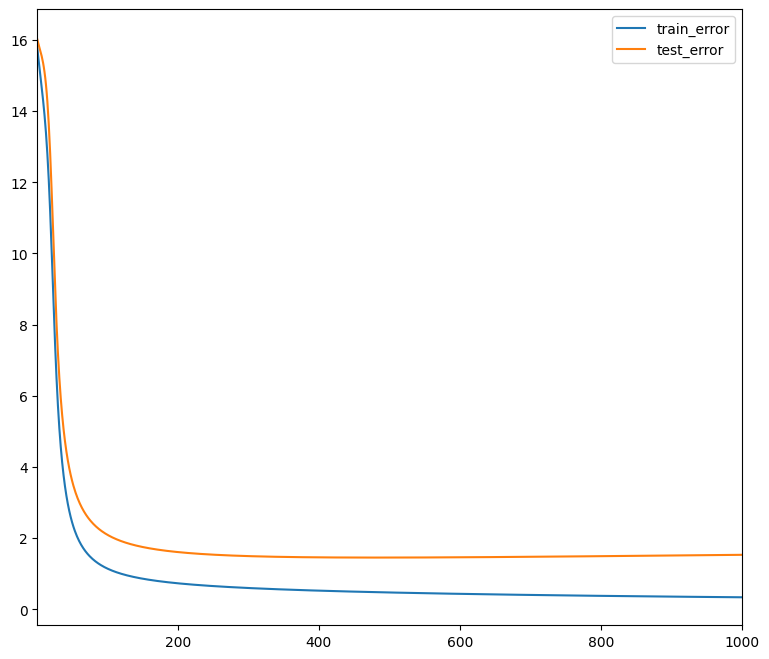

In [23]:
model = build_model(ratings, embedding_dim=35, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)

In [24]:
DOT = 'dot'
COSINE = 'cosine'

def compute_scores(query_embedding, item_embeddings, measure=DOT):
    u = query_embedding
    V = item_embeddings

    if measure == COSINE:
        V = V / np.linalg.norm(V, axis=1, keepdims=True)
        u = u / np.linalg.norm(u)
    
    scores = u.dot(V.T)

    return scores 

In [25]:
def user_recommendations(model, measure=DOT, exclude_rated=False, k=6):
    if USER_RATINGS:
        scores = compute_scores(
            model.embeddings["user_id"][943], model.embeddings["movie_id"], measure
        )
        score_key = measure + ' score'
        df = pd.DataFrame({
            score_key: list(scores),
            'movie_id': movies['movie_id'],
            'titles': movies['title'],
            'genres': movies['all_genres'],
        })

        if exclude_rated:
            # remove movies that are already rated
            rated_movies = ratings[ratings.user_id == '943']['movie_id'].values
            df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]
        
        display.display(df.sort_values([score_key], ascending=False).head(k))

def movie_neighbors(model, title_substring, measure=DOT, k=6):
    ids = movies[movies['title'].str.contains(title_substring)].index.values
    titles = movies.iloc[ids]['title'].values 

    if len(titles) == 0:
        raise ValueError("Found no movies with title %s" % title_substring)
    
    print("Nearest neightbors of %s: " % titles[0])

    if len(titles) > 1:
        print("[Found more than one matching movie. Other candidates:{}]".format(", ".join(titles[1:])))
    
    movie_id = ids[0]
    scores = compute_scores(
        model.embeddings["movie_id"][movie_id], model.embeddings["movie_id"], measure
    )

    score_key = measure + ' score'

    df = pd.DataFrame({
        score_key: list(scores),
        'titles': movies['title'],
        'genres': movies['all_genres']
    })

    display.display(df.sort_values([score_key], ascending=False).head(k))


In [26]:
user_recommendations(model, measure=COSINE, k=5)

cosine score movie_id                                      titles  \
978          0.624      978                  Trigger Effect, The (1996)   
228          0.612      228  Star Trek III: The Search for Spock (1984)   
955          0.608      955                        Nobody's Fool (1994)   
7            0.600        7                                 Babe (1995)   
1472         0.599     1472                 Little Princess, The (1939)   

                       genres  
978            Drama-Thriller  
228   Action-Adventure-Sci-Fi  
955                     Drama  
7       Children-Comedy-Drama  
1472           Children-Drama

In [27]:
movie_neighbors(model, "Aladdin", DOT)

Nearest neightbors of Aladdin (1992): 
[Found more than one matching movie. Other candidates:Aladdin and the King of Thieves (1996)]


dot score                              titles  \
94       5.836                      Aladdin (1992)   
86       5.559  Searching for Bobby Fischer (1993)   
172      5.420          Princess Bride, The (1987)   
905      5.253              Oscar & Lucinda (1997)   
63       5.190    Shawshank Redemption, The (1994)   
422      5.066   E.T. the Extra-Terrestrial (1982)   

                                genres  
94   Animation-Children-Comedy-Musical  
86                               Drama  
172    Action-Adventure-Comedy-Romance  
905                      Drama-Romance  
63                               Drama  
422      Children-Drama-Fantasy-Sci-Fi

In [28]:
movie_neighbors(model, "Aladdin", COSINE)

Nearest neightbors of Aladdin (1992): 
[Found more than one matching movie. Other candidates:Aladdin and the King of Thieves (1996)]


cosine score                              titles  \
94         1.000                      Aladdin (1992)   
14         0.818           Mr. Holland's Opus (1995)   
63         0.799    Shawshank Redemption, The (1994)   
70         0.794               Lion King, The (1994)   
86         0.786  Searching for Bobby Fischer (1993)   
0          0.783                    Toy Story (1995)   

                               genres  
94  Animation-Children-Comedy-Musical  
14                              Drama  
63                              Drama  
70         Animation-Children-Musical  
86                              Drama  
0           Animation-Children-Comedy

In [29]:
def movie_embedding_norm(models):
    if not isinstance(models, list):
        models = [models]

    df = pd.DataFrame({
        'title': movies['title'],
        'genre': movies['genre'],
        'num_ratings': movies_ratings['rating count'],
    })

    charts = []
    brush = alt.selection_interval()

    for i, model in enumerate(models):
        norm_key = 'norm'+str(i)
        df[norm_key] = np.linalg.norm(model.embeddings['movie_id'], axis=1)
        nearest = alt.selection_point(
            encodings=['x', 'y'], on='mouseover', nearest=True, empty=True
        )
        base = alt.Chart().mark_circle().encode(
            x='num_ratings',
            y=norm_key,
            color=alt.condition(brush, alt.value('steelblue'), alt.value('grey')),
            tooltip='title'
        ).properties(
            width=250,
            height=250
        ).add_params(nearest, brush)

        text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(x='num_ratings', y=norm_key, 
                                                                        text=alt.condition(nearest, 'title', alt.value('')))
        charts.append(alt.layer(base, text))
    
    return alt.hconcat(*charts, data=df)

def visualize_movie_embeddings(data, x, y):
    nearest = alt.selection_point(
        encodings=['x', 'y'], on='mouseover', nearest=True, empty='none'
    )

    base = alt.Chart().mark_circle().encode(
        x=x, 
        y=y,
        color=alt.condition(genre_filter, "genre", alt.value("whitesmoke")),
    ).properties(
        width=600,
        height=600).add_params(nearest)
    
    text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
        x=x,
        y=y, 
        text=alt.condition(nearest, 'title', alt.value('')))
    
    return alt.hconcat(alt.layer(base, text), genre_chart, data=data)

def tsne_movie_embeddings(model):
    tsne = sklearn.manifold.TSNE(
        n_components=2, perplexity=50, metric='cosine', early_exaggeration=10.0,
        init='pca', verbose=True, n_iter=5000
    )

    print("Running t-SNE...")
    V_proj = tsne.fit_transform(model.embeddings['movie_id'])
    movies.loc[:, 'x'] = V_proj[:, 0]
    movies.loc[:, 'y'] = V_proj[:, 1]

    return visualize_movie_embeddings(movies, 'x', 'y')

In [30]:
movie_embedding_norm(model)

alt.HConcatChart(...)

 iteration 1000: train_error=0.357185, test_error=0.948439Nearest neightbors of Aladdin (1992): 
[Found more than one matching movie. Other candidates:Aladdin and the King of Thieves (1996)]


dot score                            titles  \
94       5.393                    Aladdin (1992)   
63       4.903  Shawshank Redemption, The (1994)   
257      4.806                    Contact (1997)   
203      4.682         Back to the Future (1985)   
49       4.663                  Star Wars (1977)   
236      4.573              Jerry Maguire (1996)   

                                  genres  
94     Animation-Children-Comedy-Musical  
63                                 Drama  
257                         Drama-Sci-Fi  
203                        Comedy-Sci-Fi  
49   Action-Adventure-Romance-Sci-Fi-War  
236                        Drama-Romance

Nearest neightbors of Aladdin (1992): 
[Found more than one matching movie. Other candidates:Aladdin and the King of Thieves (1996)]


cosine score                           titles  \
94           1.000                   Aladdin (1992)   
458          0.868  Cry, the Beloved Country (1995)   
416          0.860          Parent Trap, The (1961)   
1599         0.846              Guantanamera (1994)   
820          0.843         Mrs. Winterbourne (1996)   
978          0.842       Trigger Effect, The (1996)   

                                 genres  
94    Animation-Children-Comedy-Musical  
458                               Drama  
416                      Children-Drama  
1599                             Comedy  
820                      Comedy-Romance  
978                      Drama-Thriller

alt.HConcatChart(...)

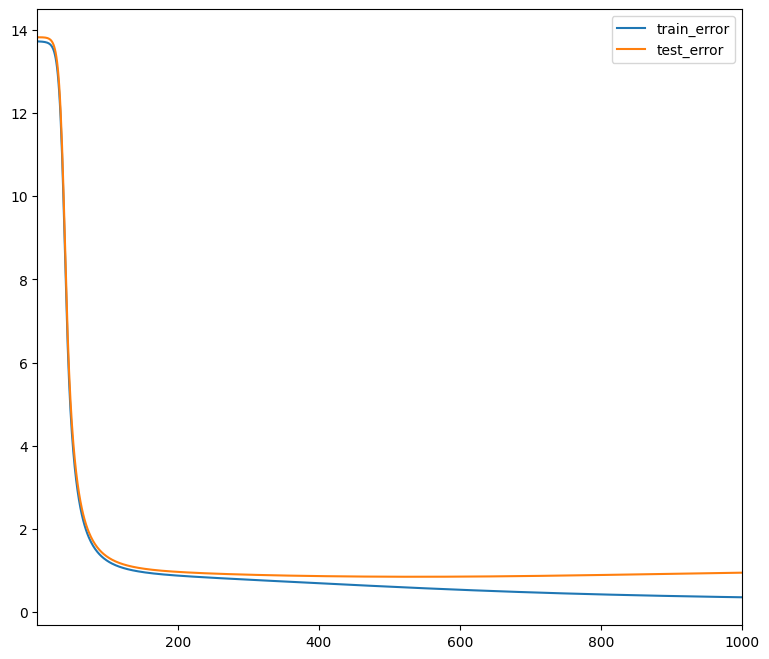

In [31]:
model_lowinit = build_model(ratings, embedding_dim=30, init_stddev=0.05)
model_lowinit.train(num_iterations=1000, learning_rate=10.)
movie_neighbors(model_lowinit, "Aladdin", DOT)
movie_neighbors(model_lowinit, "Aladdin", COSINE)
movie_embedding_norm([model, model_lowinit])

In [32]:
tsne_movie_embeddings(model_lowinit)

Running t-SNE...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1682 samples in 0.000s...
[t-SNE] Computed neighbors for 1682 samples in 0.041s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1682
[t-SNE] Computed conditional probabilities for sample 1682 / 1682
[t-SNE] Mean sigma: 0.053608
[t-SNE] KL divergence after 50 iterations with early exaggeration: 53.277229
[t-SNE] KL divergence after 3500 iterations: 2.098848


/media/d/anaconda3/envs/rec/lib/python3.10/site-packages/altair/vegalite/v5/api.py:398: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(


alt.HConcatChart(...)

- Regularization of the model parameters. This is a common $\ell_2$ regularization term on the embedding matrices, given by $r(U, V) =  \frac{1}{N} \sum_i \|U_i\|^2 + \frac{1}{M}\sum_j \|V_j\|^2$.
- A global prior that pushes the prediction of any pair towards zero, called the *gravity* term. This is given by $g(U, V) = \frac{1}{MN} \sum_{i = 1}^N \sum_{j = 1}^M \langle U_i, V_j \rangle^2$.

The total loss is then given by
$$
\frac{1}{|\Omega|}\sum_{(i, j) \in \Omega} (A_{ij} - \langle U_i, V_j\rangle)^2 + \lambda _r r(U, V) + \lambda_g g(U, V)
$$
where $\lambda_r$ and $\lambda_g$ are two regularization coefficients (hyper-parameters).

In [33]:
def gravity(U, V):
    return 1. / (U.shape[0].value * V.shape[0].value) * tf.reduce_sum(tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(ratings, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1., init_stddev=0.1):
    train_ratings, test_ratings = split_dataframe(ratings)
    A_train = build_rating_sparse_tensor(train_ratings)
    A_test = build_rating_sparse_tensor(test_ratings) 

    U = tf.Variable(tf.random_normal([A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random_normal([A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

    error_train = sparse_mean_square_error(A_train, U, V)
    error_test = sparse_mean_square_error(A_test, U, V)

    gravity_loss = gravity_coeff * gravity(U, V)
    regularization_loss = regularization_coeff * (tf.reduce_sum(U*U)/U.shape[0].value + tf.reduce_sum(V*V/V.shape[0].value))

    total_loss = error_train + regularization_loss + gravity_loss 
    losses = {
        'train_error': error_train,
        'test_error: ': error_test,
    }

    loss_components = {
        'observed_loss': error_train, 
        'regularization_loss': regularization_loss,
        'gravity_loss': gravity_loss
    }

    embeddings = {"user_id": U, "movie_id": V}

    return CFModel(embeddings, total_loss, [losses, loss_components])

 iteration 2000: train_error=1.068946, test_error: =2.359819, observed_loss=1.068946, regularization_loss=0.805178, gravity_loss=1.3405255

[{'train_error': 1.0689459, 'test_error: ': 2.3598192},
 {'observed_loss': 1.0689459,
  'regularization_loss': 0.80517846,
  'gravity_loss': 1.3405249}]

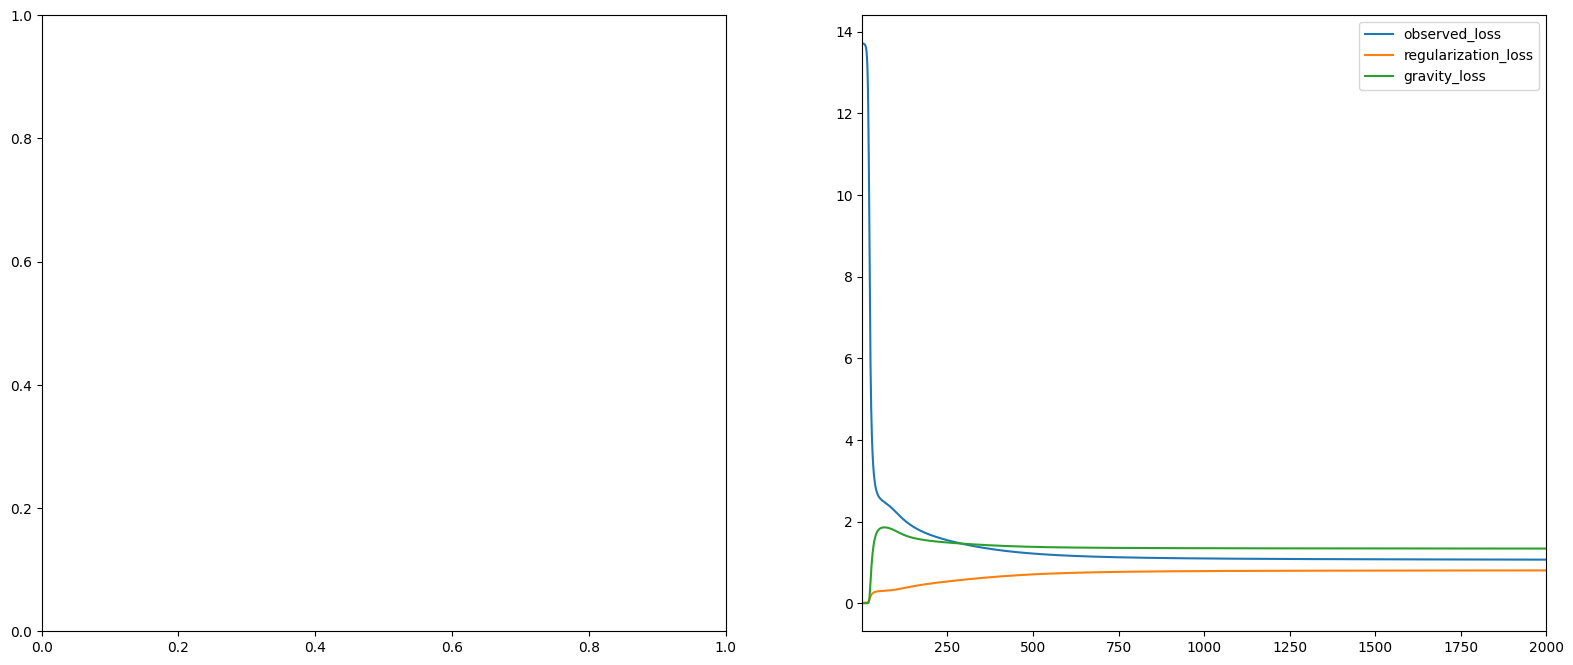

In [34]:
reg_model = build_regularized_model(ratings, regularization_coeff=0.1, gravity_coeff=1., embedding_dim=30, init_stddev=0.05) 
reg_model.train(num_iterations=2000, learning_rate=20.)

In [35]:
user_recommendations(reg_model, DOT, exclude_rated=True, k=10)

dot score movie_id                                  titles  \
426      4.496      426            To Kill a Mockingbird (1962)   
602      4.417      602                      Rear Window (1954)   
268      4.347      268                  Full Monty, The (1997)   
656      4.332      656        Manchurian Candidate, The (1962)   
510      4.127      510               Lawrence of Arabia (1962)   
133      3.996      133                     Citizen Kane (1941)   
356      3.835      356  One Flew Over the Cuckoo's Nest (1975)   
477      3.613      477          Philadelphia Story, The (1940)   
660      3.562      660                        High Noon (1952)   
44       3.524       44              Eat Drink Man Woman (1994)   

                 genres  
426               Drama  
602    Mystery-Thriller  
268              Comedy  
656  Film-Noir-Thriller  
510       Adventure-War  
133               Drama  
356               Drama  
477      Comedy-Romance  
660             Western  
44         Comedy-Drama

In [36]:
movie_neighbors(reg_model, "Aladdin", DOT)

Nearest neightbors of Aladdin (1992): 
[Found more than one matching movie. Other candidates:Aladdin and the King of Thieves (1996)]


dot score                           titles  \
94       7.811                   Aladdin (1992)   
587      7.538      Beauty and the Beast (1991)   
70       7.310            Lion King, The (1994)   
171      7.176  Empire Strikes Back, The (1980)   
173      7.152   Raiders of the Lost Ark (1981)   
201      6.839             Groundhog Day (1993)   

                                        genres  
94           Animation-Children-Comedy-Musical  
587                 Animation-Children-Musical  
70                  Animation-Children-Musical  
171  Action-Adventure-Drama-Romance-Sci-Fi-War  
173                           Action-Adventure  
201                             Comedy-Romance

In [37]:
movie_neighbors(reg_model, "Aladdin", COSINE)

Nearest neightbors of Aladdin (1992): 
[Found more than one matching movie. Other candidates:Aladdin and the King of Thieves (1996)]


cosine score                       titles  \
94          1.000               Aladdin (1992)   
587         0.908  Beauty and the Beast (1991)   
70          0.903        Lion King, The (1994)   
201         0.832         Groundhog Day (1993)   
72          0.808              Maverick (1994)   
81          0.800         Jurassic Park (1993)   

                                genres  
94   Animation-Children-Comedy-Musical  
587         Animation-Children-Musical  
70          Animation-Children-Musical  
201                     Comedy-Romance  
72               Action-Comedy-Western  
81             Action-Adventure-Sci-Fi

In [38]:
movie_embedding_norm([model, model_lowinit, reg_model])

alt.HConcatChart(...)

In [39]:
tsne_movie_embeddings(reg_model)

Running t-SNE...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1682 samples in 0.000s...
[t-SNE] Computed neighbors for 1682 samples in 0.039s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1682
[t-SNE] Computed conditional probabilities for sample 1682 / 1682
[t-SNE] Mean sigma: 0.221846
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.222980
[t-SNE] KL divergence after 5000 iterations: 1.440897


/media/d/anaconda3/envs/rec/lib/python3.10/site-packages/altair/vegalite/v5/api.py:398: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(


alt.HConcatChart(...)

In [40]:
rated_movies = (ratings[['user_id', "movie_id"]].groupby("user_id", as_index=False)
                .aggregate(lambda x: list(x)))
rated_movies.head()

user_id                                           movie_id
0       0  [60, 188, 32, 159, 19, 201, 170, 264, 154, 116...
1       1  [291, 250, 49, 313, 296, 289, 311, 280, 12, 27...
2      10  [110, 557, 731, 226, 424, 739, 722, 37, 724, 1...
3     100  [828, 303, 595, 221, 470, 404, 280, 251, 281, ...
4     101  [767, 822, 69, 514, 523, 321, 624, 160, 447, 4...

In [41]:
years_dict = {
    movie: year for movie, year in zip(movies['movie_id'], movies['year'])
}

genres_dict = {
    movie: genres.split('-') for movie, genres in zip(movies['movie_id'], movies['all_genres'])
}

def make_batch(ratings, batch_size):
    def pad(x, fill):
        return pd.DataFrame.from_dict(x).fillna(fill).values
    
    movie = [] 
    year = [] 
    genre = []
    label = []

    for movie_ids in ratings['movie_id'].values:
        movie.append(movie_ids)
        genre.append([x for movie_id in movie_ids for x in genres_dict[movie_id]])
        year.append([years_dict[movie_id] for movie_id in movie_ids])
        label.append([int(movie_id) for movie_id in movie_ids])
    
    features = {
        "movie_id": pad(movie, ""),
        "year": pad(year, ""),
        "genre": pad(genre, ""),
        "label": pad(label, -1)
    }

    batch = (
        tf.data.Dataset.from_tensor_slices(features)
        .shuffle(1000)
        .repeat()
        .batch(batch_size)
        .make_one_shot_iterator()
        .get_next()
    )

    return batch

def select_random(x):
    def to_float(x):
        return tf.cast(x, tf.float32)

    def to_int(x):
        return tf.cast(x, tf.int64)

    batch_size = tf.shape(x)[0]
    rn = tf.range(batch_size)
    nnz = to_float(tf.count_nonzero(x >= 0, axis=1))
    rnd = tf.random_uniform([batch_size])
    ids = tf.stack([to_int(rn), to_int(nnz * rnd)], axis=1)

    return to_int(tf.gather_nd(x, ids))

         

### Loss function
Recall that the softmax model maps the input features $x$ to a user embedding $\psi(x) \in \mathbb R^d$, where $d$ is the embedding dimension. This vector is then multiplied by a movie embedding matrix $V \in \mathbb R^{m \times d}$ (where $m$ is the number of movies), and the final output of the model is the softmax of the product
$$
\hat p(x) = \text{softmax}(\psi(x) V^\top).
$$
Given a target label $y$, if we denote by $p = 1_y$ a one-hot encoding of this target label, then the loss is the cross-entropy between $\hat p(x)$ and $p$.

In [42]:
def softmax_loss(user_embeddings, movie_embeddings, label):
    user_emb_dim = user_embeddings.get_shape()[1].value
    movie_emb_dim = movie_embeddings.get_shape()[1].value

    if user_emb_dim != movie_emb_dim:
        raise ValueError("Dimensions not equal")

    logits = tf.matmul(user_embeddings, movie_embeddings, transpose_b=True)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logits))

    return loss

In [43]:
def build_softmax_model(rated_movies, embedding_cols, hidden_dims):
    def create_network(features):
        inputs = tf.feature_column.input_layer(features, embedding_cols)
        input_dim = inputs.shape[1].value 

        for i, output_dim in enumerate(hidden_dims):
            w = tf.get_variable("hidden%d_w_" % i, shape=[input_dim, output_dim], 
                                initializer=tf.truncated_normal_initializer(
                                    stddev=1./np.sqrt(output_dim))) / 10.
        
            outputs = tf.matmul(inputs, w)
            input_dim = output_dim 
            inputs = outputs 

        return outputs
    
    train_rated_movies, test_rated_movies = split_dataframe(rated_movies)
    train_batch = make_batch(train_rated_movies, 200)
    test_batch = make_batch(test_rated_movies, 100)

    with tf.variable_scope("model", reuse=False):
        train_user_embeddings = create_network(train_batch)
        train_labels = select_random(train_batch["label"])
    
    with tf.variable_scope("model", reuse=True):
        test_user_embeddings = create_network(test_batch)
        test_labels = select_random(test_batch["label"])

        movie_embeddings = tf.get_variable("input_layer/movie_id_embedding/embedding_weights")
    
    test_loss = softmax_loss(test_user_embeddings, movie_embeddings, test_labels)
    train_loss = softmax_loss(train_user_embeddings, movie_embeddings, train_labels)

    _, test_precision_at_10 = tf.metrics.precision_at_k(
        labels=test_labels,
        predictions=tf.matmul(test_user_embeddings, movie_embeddings, transpose_b=True), 
        k=10
    )

    metrics = (
        {"train_loss": train_loss, "test_loss": test_loss},
        {"test_precision_at_10": test_precision_at_10}
    )

    embeddings = {"movie_id": movie_embeddings}

    return CFModel(embeddings, train_loss, metrics)

2024-02-15 07:07:26.282927: W tensorflow/c/c_api.cc:305] Operation '{name:'model_1/input_layer/year_embedding/year_lookup/hash_table/table_init/LookupTableImportV2' id:482 op device:{requested: '', assigned: ''} def:{{{node model_1/input_layer/year_embedding/year_lookup/hash_table/table_init/LookupTableImportV2}} = LookupTableImportV2[Tin=DT_STRING, Tout=DT_INT64, _has_manual_control_dependencies=true](model_1/input_layer/year_embedding/year_lookup/hash_table/hash_table, model_1/input_layer/year_embedding/year_lookup/Const, model_1/input_layer/year_embedding/year_lookup/Cast)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


 iteration 3000: train_loss=5.511384, test_loss=5.802432, test_precision_at_10=0.011082

({'train_loss': 5.5113845, 'test_loss': 5.8024316},
 {'test_precision_at_10': 0.011081639453515495})

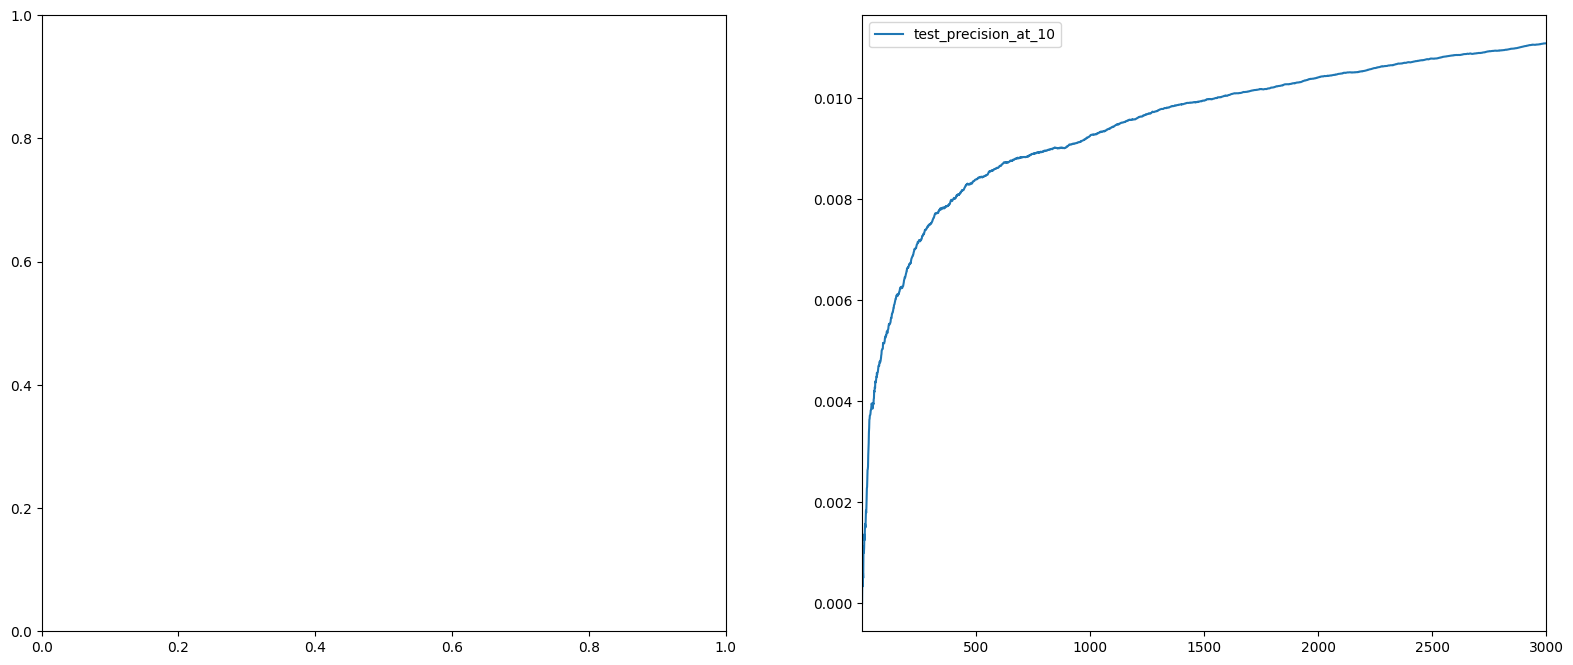

In [44]:
# Create feature embedding columns
def make_embedding_col(key, embedding_dim):
  categorical_col = tf.feature_column.categorical_column_with_vocabulary_list(
      key=key, vocabulary_list=list(set(movies[key].values)), num_oov_buckets=0)
  return tf.feature_column.embedding_column(
      categorical_column=categorical_col, dimension=embedding_dim,
      # default initializer: trancated normal with stddev=1/sqrt(dimension)
      combiner='mean')

with tf.Graph().as_default():
  softmax_model = build_softmax_model(
      rated_movies,
      embedding_cols=[
          make_embedding_col("movie_id", 35),
          make_embedding_col("genre", 3),
          make_embedding_col("year", 2),
      ],
      hidden_dims=[35])

softmax_model.train(
    learning_rate=8., num_iterations=3000, optimizer=tf.train.AdagradOptimizer)

In [45]:
movie_neighbors(softmax_model, "Aladdin", DOT)

Nearest neightbors of Aladdin (1992): 
[Found more than one matching movie. Other candidates:Aladdin and the King of Thieves (1996)]


dot score                           titles  \
49      21.119                 Star Wars (1977)   
171     20.144  Empire Strikes Back, The (1980)   
221     19.335  Star Trek: First Contact (1996)   
0       19.313                 Toy Story (1995)   
94      19.128                   Aladdin (1992)   
116     18.818                 Rock, The (1996)   

                                        genres  
49         Action-Adventure-Romance-Sci-Fi-War  
171  Action-Adventure-Drama-Romance-Sci-Fi-War  
221                    Action-Adventure-Sci-Fi  
0                    Animation-Children-Comedy  
94           Animation-Children-Comedy-Musical  
116                  Action-Adventure-Thriller

In [46]:
movie_neighbors(softmax_model, "Aladdin", COSINE)

Nearest neightbors of Aladdin (1992): 
[Found more than one matching movie. Other candidates:Aladdin and the King of Thieves (1996)]


cosine score                                  titles  \
94          1.000                          Aladdin (1992)   
70          0.902                   Lion King, The (1994)   
431         0.874                         Fantasia (1940)   
587         0.854             Beauty and the Beast (1991)   
422         0.846       E.T. the Extra-Terrestrial (1982)   
90          0.837  Nightmare Before Christmas, The (1993)   

                                genres  
94   Animation-Children-Comedy-Musical  
70          Animation-Children-Musical  
431         Animation-Children-Musical  
587         Animation-Children-Musical  
422      Children-Drama-Fantasy-Sci-Fi  
90             Children-Comedy-Musical

In [47]:
movie_embedding_norm([reg_model, softmax_model])

alt.HConcatChart(...)

In [48]:
tsne_movie_embeddings(softmax_model)

Running t-SNE...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1682 samples in 0.001s...


[t-SNE] Computed neighbors for 1682 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1682
[t-SNE] Computed conditional probabilities for sample 1682 / 1682
[t-SNE] Mean sigma: 0.116836
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.705231
[t-SNE] KL divergence after 3800 iterations: 1.212019


/media/d/anaconda3/envs/rec/lib/python3.10/site-packages/altair/vegalite/v5/api.py:398: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(


alt.HConcatChart(...)